# Building a Classifier
(This chapter is based on Raschka, chapter2)

We will build a simple classifier based on a Neuron. Neurons are nerve cells that receive input signals __x__ that determine the value of a binary output signal y. The output equals 1 if a weighted sum of the inputs surpasses some threshold value $\theta$.

Early in the history of machine learning, the use of such a neuron, then called a perceptron, was proposed. The perceptron would learn the optimal weights $\mathbf{w}$ of the inputs so as to create optimal outputs for a classification task.

<center>

<img src="images/02_01.png" align="center" width="1000" />
</center>

## The neuron's function

Suppose we have an input vector __x__ and a weight vector __w__, each of length M. We then compute their dot product $z=w_1x_1+\dots+w_Mx_M = \mathbf{w}^T\mathbf{x}$. The output then is defined as

\begin{equation*}
\phi(z) = \begin{cases}
\,\,\,\,1\text{ if } z\geq \theta\\
-1\text{ otherwise}
\end{cases}
\end{equation*}

We can, for simplicity, move the threshold $\theta$ to zero by assuming there is another input unit $x_0$ that is always 1 and that has a weight $w_0 = -\theta$. This additional input unit is usually called __bias unit__ (which has nothing to do with the term 'bias' in statistics).

The following image illustrates this function.

<center>

<img src="images/02_02.png" align="center" width="800" />
</center>

## The perceptron learning rule

<center>

<img src="images/02_04.png" align="center" width="800" />
</center>

The perceptron learns the appropriate weights from data in a simple way.

* Initially, assign small random weights to each input.
* For each sample $\mathbf{x}^{(i)}$ in the training data, compute the predicted output value $\hat{y}^{(i)}$, compare it to the observed label, and update each weight $w_j$ as follows:

\begin{equation*}
w_j^{new}= w_j+\eta\big(y^{(i)}-\hat{y}^{(i)} \big)x_j^{(i)}
\end{equation*}

$\eta$ is called the __learning rate__ and needs to be between 0 and 1.

The equation implies that we don't update the weights if the outcome has been predicted correctly. If the prediction is incorrect, the change in weights, $\Delta w_j$, becomes one of the following:

\begin{align}
\eta\big(1-(-1)\big)x_j^{(i)} &= \,\,\,\,2\eta x_j^{(i)}\\
\eta\big(-1-1\big)x_j^{(i)} &= -2\eta x_j^{(i)}
\end{align}

That means, e.g., that we increase $w_j$ if $x_j^{(i)}$ is positive and we incorrectly predicted the outcome $-1$.

The convergence of the perceptron is guaranteed only if the two classes are linearly separable and the learning rate is sufficiently small.

<center>

<img src="images/02_03.png" align="center" width="1200" />
</center>

If we suspect that the classes may not be linearly separable, we need to choose a criterion that determines when to stop the learning process. E.g., we can decide to use only a maximum of K __epochs__. Each epoch in ML corresponds to using each sample in the training data once.

We could also set a maximum number of wrong classifications that we are willing to accept. That requires knowledge of the accuracy the perceptron can actually achieve in the given task.

# Implementing a perceptron learning algorithm

In [19]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.colors import ListedColormap

We are going to use OOP and create a class `Perceptron`. It will enable us to create Perceptron objects, which can then apply the learning algorithm to data sets. We will begin with writing the constructor. We have seen that the constructor may need to accept the following arguments:

* the learning rate `eta`
* the maximum number of epochs `n_iter`, i.e., the maximum number of iterations over the training data
* a seed `random_state` for a random number generator so that we can initially assign random weights to the inputs

We can then write the following constructor. We include default values for each parameter.

In [20]:
class Perceptron(object):
    """Perceptron classifier.

    Parameters
    ------------
    eta : float
      Learning rate (between 0.0 and 1.0)
    n_iter : int
      Passes over the training dataset.
    random_state : int
      Random number generator seed for random weight
      initialization.

    """
    def __init__(self, eta=0.01, n_iter=50, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state

We next add a method `fit` responsible for training the perceptron. This method receives the training data separated into the feature matrix __X__ and the label vector __y__ as parameters. Each row of __X__ contains the feature vector of one sample.

We also define a method `predict` that we can use both to compute predicted values in the learning process and to later predict labels for the test data.

A method `net_input` simply computes the weighted sum of the inputs that is used to decide whether to predict 1 or -1.

Let us begin by considering the latter two methods first.

`net_input` takes the vector __x__ of a sample and computes the weighted sum by calculating the dot product with the vector `w_`, which is an attribute of the Perceptron object. Note that the method's return value includes the weight of the bias unit stored in `w_[0]`.

`predict` takes the vector __x__, passes it to `net_input`, and returns 1 if the `net_input` returns a value greater than or equal to zero, and -1 otherwise. It uses the numpy function `where` that returns elements from one of two array-like objects, though these objects are simply the numbers 1 and -1 here.

In [21]:
    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def predict(self, X):
        """Return class label after unit step"""
        return np.where(self.net_input(X) >= 0.0, 1, -1)

In the `fit` method, we first generate a `RandomState` object that we then use to obtain small random weights needed to initialize the weights. This includes the weight for the bias unit, which is not contained in the feature matrix __X__.

We create the attribute `errors_` as an empty list. It is then used to store the number of wrong classifications for each epoch.

We loop `n_iter` times over the whole training set. Within each epoch, we loop over all samples, updating the weight vector based on misclassifications every time.

'''
"""
    Attributes
    -----------
    w_ : 1d-array
      Weights after fitting.
    errors_ : list
      Number of misclassifications (updates) in each epoch.

"""
 
def fit(self, X, y):
        """Fit training data.

        Parameters
        ----------
        X : {array-like}, shape = [n_samples, n_features]
          Training vectors, where n_samples is the number of samples and
          n_features is the number of features.
        y : array-like, shape = [n_samples]
          Target values.

        Returns
        -------
        self : object

        """
    rgen = np.random.RandomState(self.random_state)
    self.w_ = rgen.normal(loc=0.0, scale=0.01, size=1 + X.shape[1])
    self.errors_ = []

    for _ in range(self.n_iter):
        errors = 0
        for xi, target in zip(X, y):
            update = self.eta * (target - self.predict(xi))
            self.w_[1:] += update * xi
            self.w_[0] += update
            errors += int(update != 0.0)
        self.errors_.append(errors)
    return self
 '''

Putting it all together:

In [22]:
class Perceptron(object):
    """Perceptron classifier.

    Parameters
    ------------
    eta : float
      Learning rate (between 0.0 and 1.0)
    n_iter : int
      Passes over the training dataset.
    random_state : int
      Random number generator seed for random weight
      initialization.

    Attributes
    -----------
    w_ : 1d-array
      Weights after fitting.
    errors_ : list
      Number of misclassifications (updates) in each epoch.

    """
    def __init__(self, eta=0.01, n_iter=50, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state

    def fit(self, X, y):
        """Fit training data.

        Parameters
        ----------
        X : {array-like}, shape = [n_samples, n_features]
          Training vectors, where n_samples is the number of samples and
          n_features is the number of features.
        y : array-like, shape = [n_samples]
          Target values.

        Returns
        -------
        self : object

        """
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=1 + X.shape[1])
        self.errors_ = []

        for _ in range(self.n_iter):
            errors = 0
            for xi, target in zip(X, y):
                update = self.eta * (target - self.predict(xi))
                self.w_[1:] += update * xi
                self.w_[0] += update
                errors += int(update != 0.0)
            self.errors_.append(errors)
        return self

    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def predict(self, X):
        """Return class label after unit step"""
        return np.where(self.net_input(X) >= 0.0, 1, -1)

## Training a perceptron model on the Iris dataset

We will use a commonly used dataset for the classification of types of flowers to illustrate the usage of our `Perceptron` class. This data can be read in remotely.

In [23]:
df = pd.read_csv('https://archive.ics.uci.edu/ml/'
        'machine-learning-databases/iris/iris.data', header=None)
df.tail()

,0,1,2,3,4
145,6.7,3.0,5.2,2.3,Iris-virginica
146,6.3,2.5,5.0,1.9,Iris-virginica
147,6.5,3.0,5.2,2.0,Iris-virginica
148,6.2,3.4,5.4,2.3,Iris-virginica
149,5.9,3.0,5.1,1.8,Iris-virginica


To be better able to illustrate the algorithm, we will use only two features and two types of flowers. It would be possible to adapt the `Perceptron` class to be able to deal with more than two outcome labels.

The data are sorted by types of flower. Therefore, we take the first 100 samples (flowers of type 'setosa' and 'versicolor'). We convert those labels to the values -1 and 1.

In [24]:
y = df.iloc[0:100, 4].values
y = np.where(y == 'Iris-setosa', -1, 1)

We will use only the first and third features.

In [25]:
X = df.iloc[0:100, [0, 2]].values

We can take a look at the data.

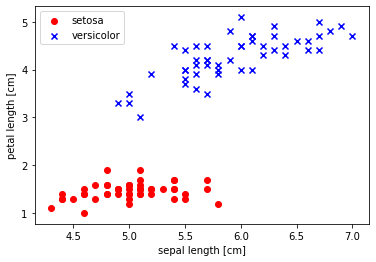

In [26]:
plt.scatter(X[:50, 0], X[:50, 1],
            color='red', marker='o', label='setosa')
plt.scatter(X[50:100, 0], X[50:100, 1],
            color='blue', marker='x', label='versicolor')

plt.xlabel('sepal length [cm]')
plt.ylabel('petal length [cm]')
plt.legend(loc='upper left')
plt.show()

### Training the perceptron model

We train the model with arbitrarily chosen parameters.

In [27]:
ppn = Perceptron(eta=0.1, n_iter=10)
ppn.fit(X, y)

The `errors_` attribute shows how many flowers were misclassified in each epoch, and, accordingly, how many times the weights were updated.

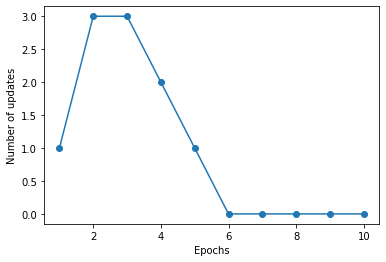

In [28]:
plt.plot(range(1, len(ppn.errors_) + 1), ppn.errors_, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Number of updates')
plt.show()

### Plotting decision regions
To see which combinations of the two features would have predicted which labels, we can, since we have only two features, plot decision regions. The following function implements such plots.

In [29]:
def plot_decision_regions(X, y, classifier, resolution=0.02):

    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # plot class samples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.8, 
                    c=colors[idx],
                    marker=markers[idx], 
                    label=cl)

We apply this function to our data and classifier.

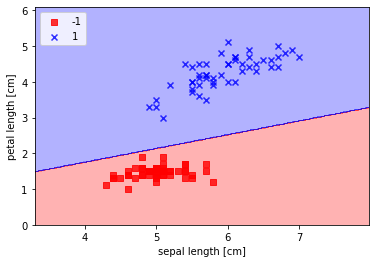

In [30]:
plot_decision_regions(X, y, classifier=ppn)
plt.xlabel('sepal length [cm]')
plt.ylabel('petal length [cm]')
plt.legend(loc='upper left')
plt.show()

# Adaptive linear neurons and the convergence of learning

We will next consider an alternative specification of a neuron that is called Adaline. The important difference compared to the perceptron is that we consider not only whether a prediction is correct, but instead take into account the value of an activation function returning continuous values. In the case of Adaline, the activation function is simply the identity, i.e., the activation function returns the net input, though it would be possible to choose different activation functions.


Based on this activation function, we can then, instead of having binary errors, apply a more sophisticated __objective function__ that evaluates the quality of the predictions. The objective function is often expressed as a __cost function__. The cost function used by Adaline is the __Sum of Squared Errors__ (SSE)
\begin{equation*}
J(\mathbf{w}) = \frac{1}{2}\sum_i\Big(y^{(i)}-\phi\big( z^{(i)} \big) \Big)^2
\end{equation*}

<center>

<img src="images/02_09.png" align="center" width="1200" />
</center>

An important advantage of this cost function is that it is differentiable. It also happens to be convex, such that we can use __gradient descent__ optimization.

As the figure suggests, gradient descent resembles stepping down the cost function towards a (global or local) minimum.

<center>

<img src="images/02_10.png" align="center" width="800" />
</center>

Gradient descent updates weights by the product of the negative of the gradient $\nabla J(\mathbf{w})$ and the learning rate $\eta$.

\begin{align}
\Delta\mathbf{w} =-\eta\nabla J(\mathbf{w})
\end{align}

We compute the gradient by calculating the partial derivative of the costs function with respect to each weight $w_j$ (see the derivation in Raschka).

\begin{align}
\frac{\partial J}{\partial w_j} = -\sum_i\Big(y^{(i)} -\phi\big(z^{(i)} \big) \Big)x_j^{(i)}
\end{align}

The update to each weight $w_j$ is then

\begin{align}
\Delta w_j = -\eta\frac{\partial J}{\partial w_j} = \eta\sum_i\Big(y^{(i)} -\phi\big(z^{(i)} \big) \Big)x_j^{(i)}
\end{align}

This learning rule looks like that for the Perceptron, except that $\phi$ here is a continuous function instead of the step function.

We update the weights here taking into account all samples in the training data simultaneously. This approach is called __batch gradient descent__.

## Implementing Adaline

The implementation is very similar to that of the Perceptron, except that we need to adjust the `fit` method. When updating the weights, we use the value of the activation function instead of  the predicted label and update the weights once per iteration. The cost is computed as defined above.

In [31]:
class AdalineGD(object):
    """ADAptive LInear NEuron classifier.

    Parameters
    ------------
    eta : float
      Learning rate (between 0.0 and 1.0)
    n_iter : int
      Passes over the training dataset.
    random_state : int
      Random number generator seed for random weight
      initialization.


    Attributes
    -----------
    w_ : 1d-array
      Weights after fitting.
    cost_ : list
      Sum-of-squares cost function value in each epoch.

    """
    def __init__(self, eta=0.01, n_iter=50, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state

    def fit(self, X, y):
        """ Fit training data.

        Parameters
        ----------
        X : {array-like}, shape = [n_samples, n_features]
          Training vectors, where n_samples is the number of samples and
          n_features is the number of features.
        y : array-like, shape = [n_samples]
          Target values.

        Returns
        -------
        self : object

        """
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=1 + X.shape[1])
        self.cost_ = []

        for i in range(self.n_iter):
            net_input = self.net_input(X)
            # Please note that the "activation" method has no effect
            # in the code since it is simply an identity function. We
            # could write `output = self.net_input(X)` directly instead.
            # The purpose of the activation is more conceptual, i.e.,  
            # in the case of logistic regression (as we will see later), 
            # we could change it to
            # a sigmoid function to implement a logistic regression classifier.
            output = self.activation(net_input)
            errors = (y - output)
            self.w_[1:] += self.eta * X.T.dot(errors)
            self.w_[0] += self.eta * errors.sum()
            cost = (errors**2).sum() / 2.0
            self.cost_.append(cost)
        return self

    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def activation(self, X):
        """Compute linear activation"""
        return X

    def predict(self, X):
        """Return class label after unit step"""
        return np.where(self.activation(self.net_input(X)) >= 0.0, 1, -1)

We apply the Adaline learning algorithm to the same flower classification task as before, using two different learning rates.

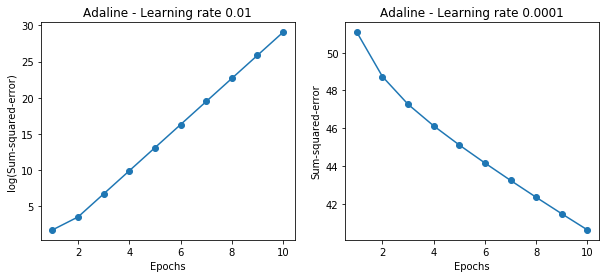

In [42]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

ada1 = AdalineGD(n_iter=10, eta=0.01).fit(X, y)
ax[0].plot(range(1, len(ada1.cost_) + 1), np.log10(ada1.cost_), marker='o')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('log(Sum-squared-error)')
ax[0].set_title('Adaline - Learning rate 0.01')

ada2 = AdalineGD(n_iter=10, eta=0.0001).fit(X, y)
ax[1].plot(range(1, len(ada2.cost_) + 1), ada2.cost_, marker='o')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Sum-squared-error')
ax[1].set_title('Adaline - Learning rate 0.0001')

plt.show()

The plots show two different problems: for $\eta = 0.01$, the errors become larger with each epoch, suggesting that the steps taken in the gradient descent overshoot the minimum of the cost function. For $\eta = 0.0001$, the errors decrease with each epoch, but they do so very slowly and don't show any signs of convergence after 10 iterations.

The image below illustrates an application with appropriately chosen learning rate on the left, and one with too large a learning rate on the right
<center>

<img src="images/02_12.png" align="center" width="1200" />
</center>

## Feature scaling

Many machine learning algorithms, including gradient descent, benefit from __feature scaling__, i.e., making the scales of the features comparable. One common method of feature scaling is __standardization__, i.e., substraction of the sample mean and division by the sample standard deviation.

\begin{align}
\mathbf{x}_j^{'} &= \frac{\mathbf{x}_j-\mathbf{\mu}_j}{\sigma_j}
\end{align}

The figure below gives an idea why standardization can be useful.
<center>

<img src="images/02_13.png" align="center" width="800" />
</center>

We will standardize our data and apply the Adaline Gradient Descent to the standardized data, using the learning rate that led to a failure to converge earlier.

In [43]:
X_std = np.copy(X)
X_std[:, 0] = (X[:, 0] - X[:, 0].mean()) / X[:, 0].std()
X_std[:, 1] = (X[:, 1] - X[:, 1].mean()) / X[:, 1].std()

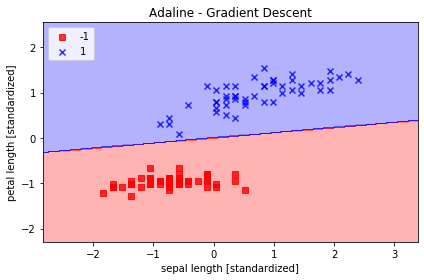

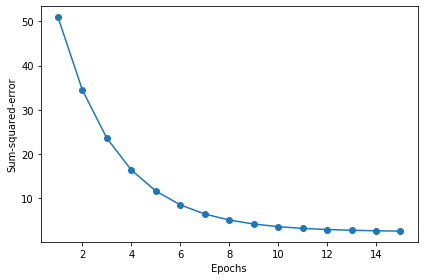

In [44]:
ada = AdalineGD(n_iter=15, eta=0.01) #eta=learning rate
ada.fit(X_std, y)

plot_decision_regions(X_std, y, classifier=ada)
plt.title('Adaline - Gradient Descent')
plt.xlabel('sepal length [standardized]')
plt.ylabel('petal length [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

plt.plot(range(1, len(ada.cost_) + 1), ada.cost_, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Sum-squared-error')

plt.tight_layout()
plt.show()